# Level 2 VQ-VAE Run Script

## Import a bunch of libraries

In [1]:
import IPython

import torch
from torch.utils.data import DataLoader
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.multi_level_vqvae import MultiLvlVQVariationalAutoEncoder
from loaders.music_loader import MP3SliceDataset
from loaders.lvl2_loader import Lvl2InputDataset
from utils.other import load_cfg_dict

/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load configuration file and add weights path

In [2]:
config_path_lvl1 = "config/lvl1_config.yaml"
weights_path_lvl1 = "model_weights/lvl1_vqvae.ckpt"
#weights_path = "model_best.ckpt"
cfg_1 = load_cfg_dict(config_path_lvl1)

config_path_lvl2 = "config/lvl2_config.yaml"
weights_path_lvl2 = "model_weights/lvl2_vqvae.ckpt"
#weights_path = "model_best.ckpt"
cfg_2 = load_cfg_dict(config_path_lvl2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define Mel Spectrogram

In [3]:
mel_spec_new = torchaudio.transforms.MelSpectrogram(n_fft=512, hop_length=128, n_mels=128, 
                                                    pad_mode='reflect', power=1.0, norm= "slaney", mel_scale= "htk").to(device)

/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


## Load the models

In [4]:
model_lvl1 = MultiLvlVQVariationalAutoEncoder(**cfg_1).to(device)
model_lvl1 = model_lvl1.load_from_checkpoint(weights_path_lvl1, **cfg_1, strict=False).to(device)
model_lvl1.eval()

model_lvl2 = MultiLvlVQVariationalAutoEncoder(**cfg_2).to(device)
model_lvl2 = model_lvl2.load_from_checkpoint(weights_path_lvl2, **cfg_2, strict=False).to(device)
model_lvl2.eval()

/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/home/tcv1tv/anaconda3/envs/IDHF/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has

MultiLvlVQVariationalAutoEncoder(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (mel_spec_sub_1): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (mel_spec_sub_2): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (encoder): Encoder1D(
    (init_conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv_list): ModuleList(
      (0): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (1): GELU(approximate=none)
          (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): GELU(approximate=none)
        )
      )
      (1): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
     

### HTML wrapper to display sound clips:

In [5]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load a dataset sample and display it.

### Create a mel weight matrix

In [6]:
lin_vector = torch.linspace(0.1, 5, 128)
eye_mat = torch.diag(lin_vector).to(device)

### Load the slice

Loading file data/music_samples/001-datatensor.pt...
Music file data/music_samples/001-datatensor.pt is loaded.
Loading file data/music_samples/001-metadata.pkl...
Music file data/music_samples/001-metadata.pkl is loaded.
Current track is data/music_samples/04-infected_mushroom_-_infected_mushroom_-_the_shen-psycz-vbr.mp3


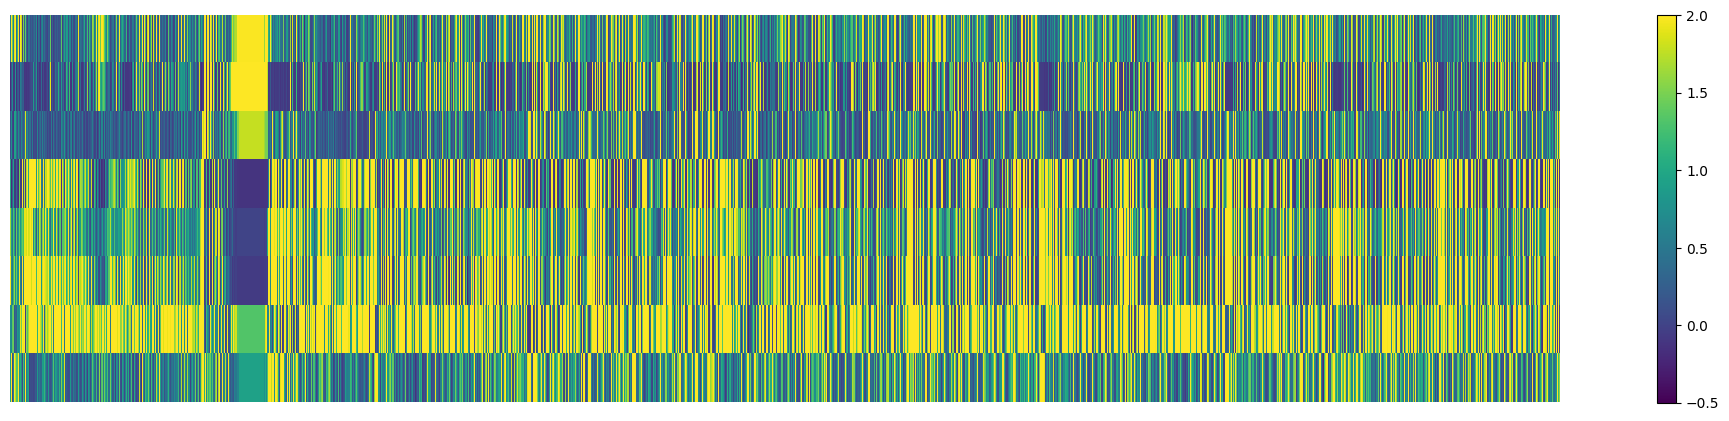

In [7]:
dataset = Lvl2InputDataset(preload=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for sample in dataloader:
    lvl2_sample = sample['music slice'].squeeze(0)
    print(f"Current track is {sample['track name'][0]}")
    break
plt.figure(figsize=(25, 5))
plt.matshow(lvl2_sample.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-0.5, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Run the lvl 2 network and show results

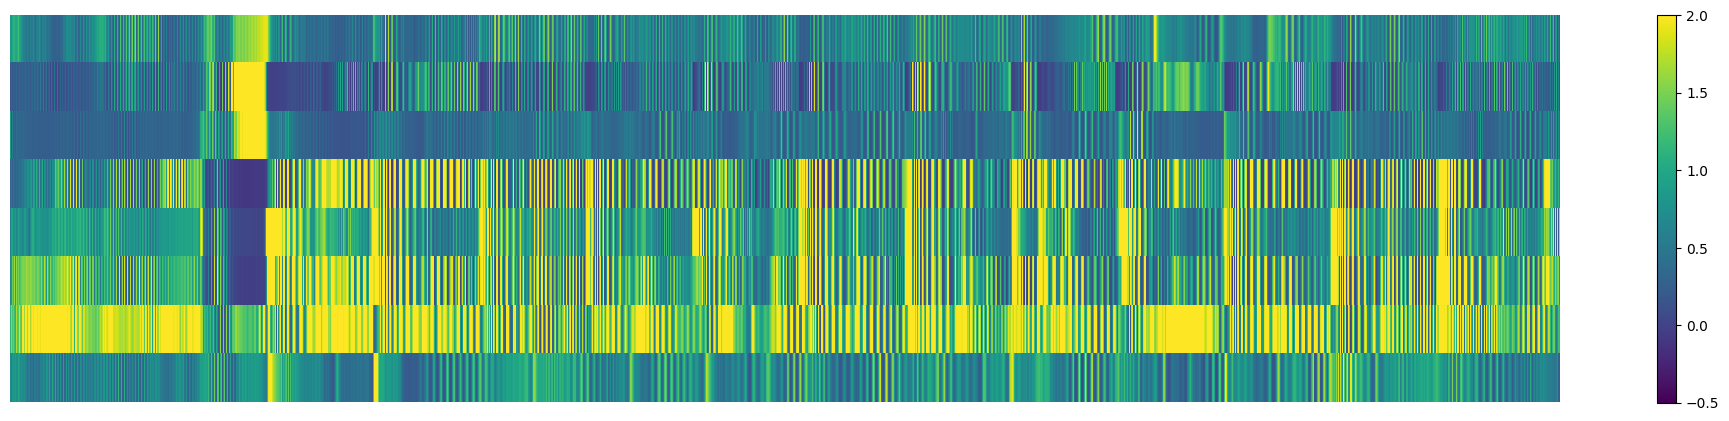

torch.Size([8, 4096]) torch.Size([8, 4096])


In [8]:
lvl2_output = model_lvl2(lvl2_sample.clone().unsqueeze(0).to(device), extract_losses=False)
with torch.no_grad():
    lvl1_pred = lvl2_output['output'][0]
plt.figure(figsize=(25, 5))
plt.matshow(lvl1_pred.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-0.5, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()
print(lvl1_pred.size(), lvl2_sample.size())

## Show the subtraction between the ground truth and the reconstruction

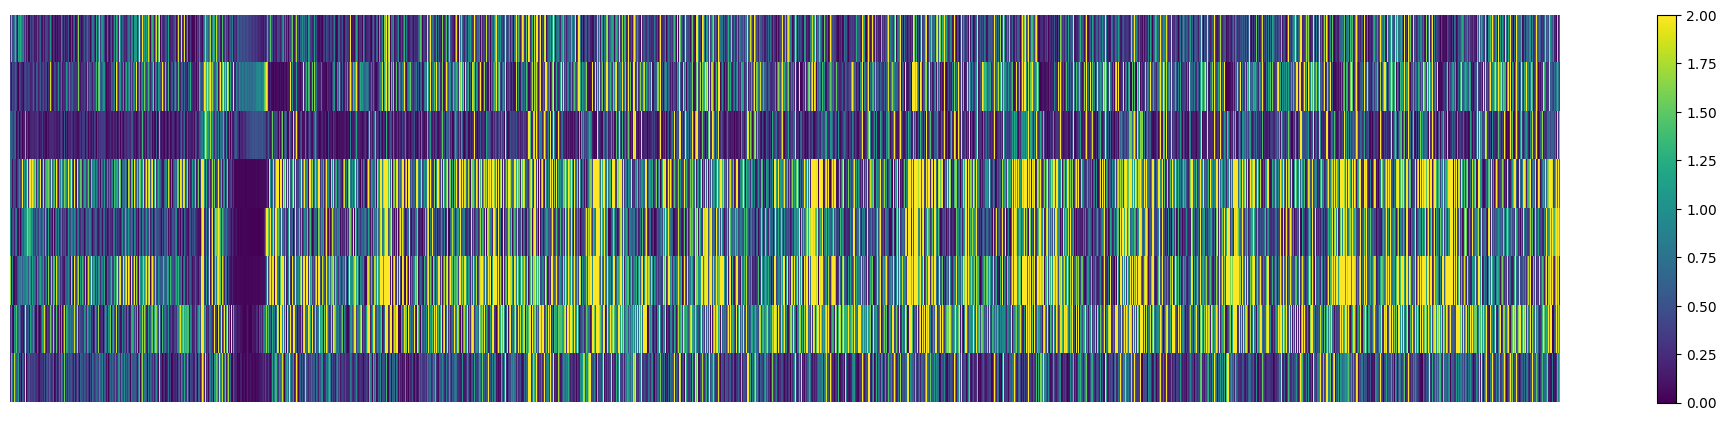

In [9]:
plt.figure(figsize=(25, 5))
plt.matshow(torch.abs(lvl2_sample.cpu() - lvl1_pred.cpu()).detach().numpy(), fignum=1, aspect='auto', vmin=0, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Pass the level 2 outputs through the level 1 decoder and make MUSIC!

### Sanity Check, reconstruction of the lvl1 data

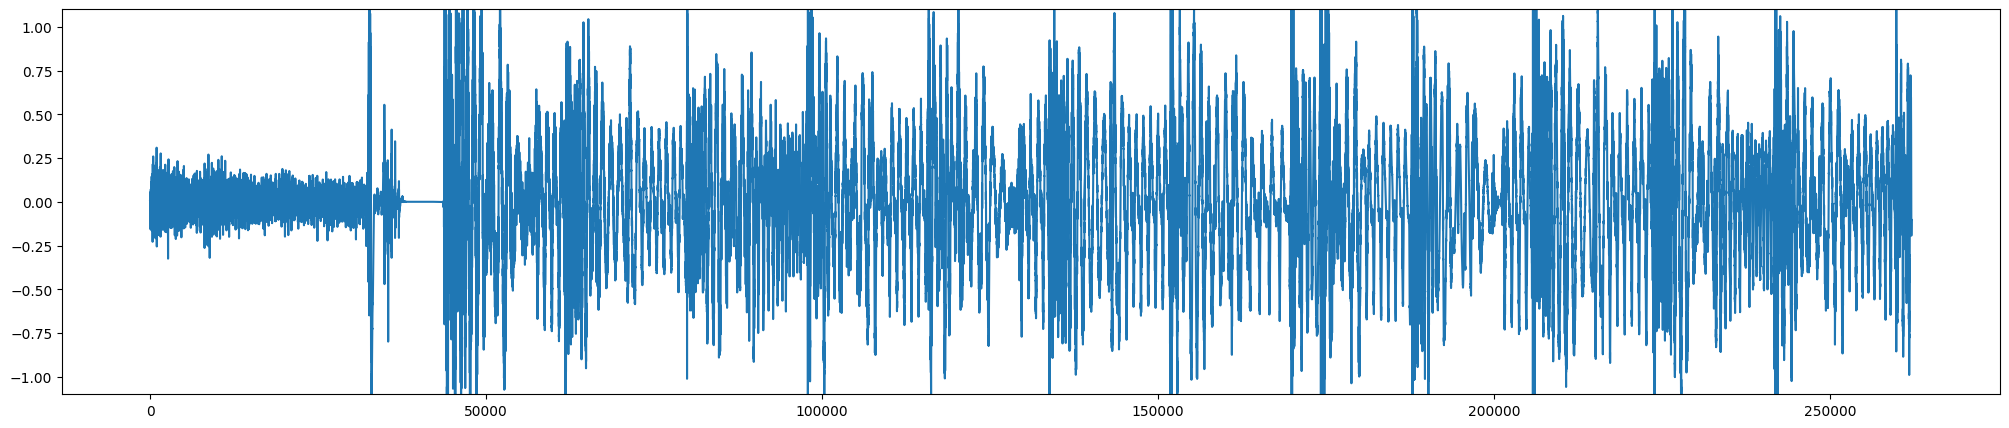

In [10]:
# vq_input = torch.zeros((8, 8, 512)).to(device)
# for idx in range(8):
#     vq_input[idx, :, :] = lvl2_sample[:, idx * 512: (idx + 1) * 512]

with torch.no_grad():
    # z_q_out = vq_input
    z_q_out = model_lvl1.vq_module(lvl2_sample.unsqueeze(0).to(device))['v_q']
    output = model_lvl1.decoder(z_q_out)
    
music_sample_rec = output.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

### CREATE *MUSIC*!!!

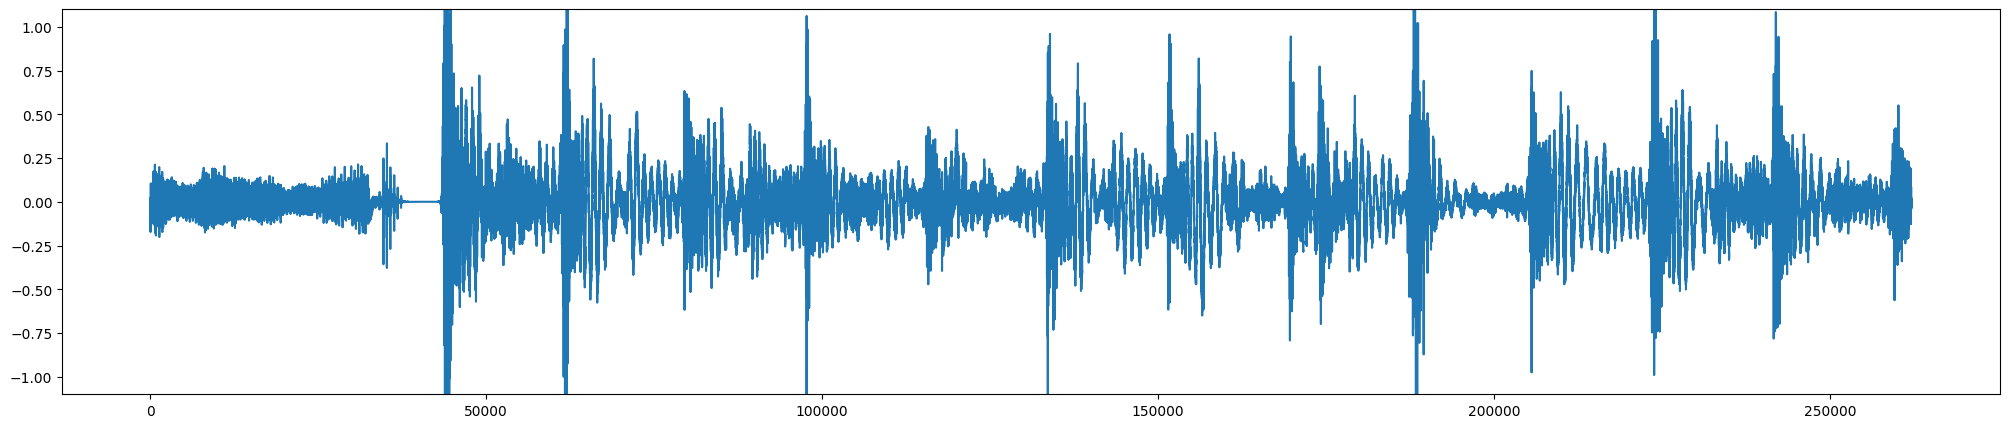

In [11]:
with torch.no_grad():
    # z_q_out = vq_input
    z_q_out = model_lvl1.vq_module(lvl1_pred.unsqueeze(0).to(device))['v_q']
    output = model_lvl1.decoder(z_q_out)
    
music_sample_rec = output.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")